In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9
import random

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


pd.options.display.max_columns= None


from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']

mycolors = ['#447672', '#ee6d71', '#8fc0e0', '#ffb947', '#4e445f', '#d1d882', '#9D7558', 
            '#a7d8d4', '#ffaeac', '#b0b7bd', '#fce4c9', '#bfb4d2', '#5b83a8', '#575757']


p9_template = (p9.theme_seaborn() 
             + p9.theme(
                 rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
                 panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
                 strip_text=p9.element_text(size=14),
                 text=p9.element_text(size=17),
                 subplots_adjust={'hspace': 0.31, 'wspace': 0.31}
             )
            )

mytheme_high = p9_template + p9.theme(figure_size = (10, 7.5))
mytheme_wide = p9_template + p9.theme(figure_size = (15, 7.5))
mytheme_wider = p9_template + p9.theme(figure_size = (15, 5))


In [2]:
data = pd.read_csv('barkbeetle_dataset.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])

In [3]:
# TODO: move to other notebook
data['area_endangered'] = data[['forest_ownership', 'area_nse', 'area_se']].apply(lambda x: x[1] if x[0] == 'NSW' else x[2], axis=1)

In [4]:
# TODO: remove pre 2006 and post feb2020 
data = data[data['timestamp'].isin(pd.date_range(start='2006-01-01', end='2020-02-29', freq='M'))]

In [5]:
# # aggregate NSW and SW
# data[['infested_wood', 'area_endangered', 'prev_infested_wood', 'prev_infested_wood_rollsr', 'prev_infested_wood_rollwr']]= data.groupby(['timestamp', 'fdist_newname'])[['infested_wood', 'area_endangered', 'prev_infested_wood', 'prev_infested_wood_rollsr', 'prev_infested_wood_rollwr']].transform('sum')
# data.drop_duplicates(['timestamp', 'fdist_newname'], inplace=True, ignore_index=True)
# 
# data['id'] = data['id'].map(lambda x: '-'.join(x.split('-')[:2]))

In [6]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[['timeframe', 'id', 'area_endangered', 'timestamp', 'centroid_xcoord', 'centroid_ycoord', 
          'TM0', 'RGK', 'KWK', 'prev_infested_wood', 'TM0_rollsr', 'RGK_rollsr', 'KWK_rollsr', 'prev_infested_wood_rollsr', 'TM0_rollwr', 'RGK_rollwr', 'KWK_rollwr', 'prev_infested_wood_rollwr']]

In [7]:
X.head()

,timeframe,id,area_endangered,timestamp,centroid_xcoord,centroid_ycoord,TM0,RGK,KWK,prev_infested_wood,TM0_rollsr,RGK_rollsr,KWK_rollsr,prev_infested_wood_rollsr,TM0_rollwr,RGK_rollwr,KWK_rollwr,prev_infested_wood_rollwr
0,06 Juni,Bautzen-Elsterheide-SW,26.85,2007-06-30,451775.13571,5.704409e+06,18.961279,150.442419,-37.537037,0.0,17.260886,144.731032,-52.174580,0.0,2.251927,42.071269,27.894333,0.0
1,06 Juni,Bautzen-Elsterheide-NSW,11.37,2007-06-30,451775.13571,5.704409e+06,18.961279,150.442419,-37.537037,0.0,17.260886,144.731032,-52.174580,0.0,2.251927,42.071269,27.894333,0.0
2,08 August,Bautzen-Elsterheide-SW,26.85,2007-08-31,451775.13571,5.704409e+06,18.506060,133.832676,-43.587545,0.0,16.749046,139.227836,-41.574411,5.0,2.251927,42.071269,27.894333,5.0
3,08 August,Bautzen-Elsterheide-NSW,11.37,2007-08-31,451775.13571,5.704409e+06,18.506060,133.832676,-43.587545,0.0,16.749046,139.227836,-41.574411,0.0,2.251927,42.071269,27.894333,0.0
4,10 Oktober-Dezember,Bautzen-Elsterheide-SW,26.85,2007-12-31,451775.13571,5.704409e+06,4.503592,97.931986,76.421211,0.0,16.047250,134.313302,-26.482604,17.0,1.637392,39.827834,29.652133,17.0


## train-val-test split

In [8]:
train_ratio = 0.80
val_ratio = 0.10
test_ratio = 0.10

# make train set according to train_ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1 - train_ratio, 
                                                    random_state=0)

# make validation and test set according to val_ratio and test_ratio
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + val_ratio), 
                                                random_state=0, 
                                                shuffle=False)  # shuffle already done in first split

# Show the results of the split
print ('Training set has {} samples.'.format(X_train.shape[0]))
print ('Validation set has {} samples.'.format(X_val.shape[0]))
print ('Testing set has {} samples.'.format(X_test.shape[0]))

Training set has 9515 samples.
Validation set has 1189 samples.
Testing set has 1190 samples.


In [9]:
# remove and save ids and timestamps from the sets
# can be used to show model predictions later 
id_train, ts_train = X_train.pop('id'), X_train.pop('timestamp')
id_val, ts_val = X_val.pop('id'), X_val.pop('timestamp')
id_test, ts_test = X_test.pop('id'), X_test.pop('timestamp')

## Engineer Month Feature

In [10]:
# TODO: diese Funktion als custom pipeline

def month_num_encoder(X_train, y_train, X_val, X_test):
    '''
    TODO: documentation
    '''
        
    # get a factor for every timeframe
    # factor = how much of the yearly infestation was observed in the respective timeframe
    
    # merge timeframe column from X_train with y_train (target)
    tf_y = pd.DataFrame({'timeframe': X_train['timeframe'], 'target': y_train})
    
    # group by timeframe and take the mean of target
    tf_y = tf_y.groupby('timeframe').mean()
    
    # get the sum of all groups
    total = tf_y['target'].sum()
    
    # make a dictionary that maps the timeframe to the ratio it contributes to the target on average
    transform_dict = tf_y['target'].map(lambda x: x/total).to_dict()
    
    # use these factors (one numerical feature) in train, val and test sets
    # instead of the timeframe feature (categorial with 8 categories)
    # since we only used the knowledge on our targets of the train set (y_train) there is no data leakage 
    
    new_X_train = X_train.copy()
    new_X_train['timeframe'] = new_X_train['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_val = X_val.copy()
    new_X_val['timeframe'] = new_X_val['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_test = X_test.copy()
    new_X_test['timeframe'] = new_X_test['timeframe'].map(lambda x: transform_dict.get(x))
    
    return new_X_train, new_X_val, new_X_test

In [11]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timeframe                  9515 non-null   float64
 1   area_endangered            9515 non-null   float64
 2   centroid_xcoord            9515 non-null   float64
 3   centroid_ycoord            9515 non-null   float64
 4   TM0                        9515 non-null   float64
 5   RGK                        9515 non-null   float64
 6   KWK                        9515 non-null   float64
 7   prev_infested_wood         9513 non-null   float64
 8   TM0_rollsr                 9502 non-null   float64
 9   RGK_rollsr                 9502 non-null   float64
 10  KWK_rollsr                 9502 non-null   float64
 11  prev_infested_wood_rollsr  9500 non-null   float64
 12  TM0_rollwr                 9502 non-null   float64
 13  RGK_rollwr                 9502 non-null   fl

## Pipeline

In [13]:
# Creating list for categorical predictors/features 
# Should not have any but we leave it in for robustness sake (TODO:remove)
cat_features = list(X_train.columns[X_train.dtypes==object])
print(f'Categorical features: {cat_features}')

# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(X_train.columns[X_train.dtypes!=object])
print(f'Numerical features: {num_features}')

Categorical features: []
Numerical features: ['timeframe', 'area_endangered', 'centroid_xcoord', 'centroid_ycoord', 'TM0', 'RGK', 'KWK', 'prev_infested_wood', 'TM0_rollsr', 'RGK_rollsr', 'KWK_rollsr', 'prev_infested_wood_rollsr', 'TM0_rollwr', 'RGK_rollwr', 'KWK_rollwr', 'prev_infested_wood_rollwr']


In [14]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()) # Standardscaler not needed if we use Decision Tree Based Models
])

# Pipeline for categorical features 
# don't have those for now but keep it in for robustness' sake
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [15]:

# Building a full pipeline with our preprocessor and a Regressor
pipe_xgbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

pipe_rfr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(criterion='mae', random_state=0, n_jobs=-1))
])

pipe_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(criterion='mae', random_state=0))
])

pipe_knr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_jobs=-1))
])

pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

pipelines = [pipe_xgbr, pipe_knr, pipe_svr, pipe_rfr, pipe_gbr]

In [49]:
# Making predictions on the training set using cross validation
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)

for pipe in pipelines:
    print(f'Cross validation scores for {pipe.steps[1][1]}:')
    y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)
    # Calculating the mean sqaured error, mean absolute error and explained variance for 
    print('-------------------------')
    print('MSE: {:.2f}'.format(mean_squared_error(y_train, y_train_predicted)))
    print('MAE: {:.2f}'.format(mean_absolute_error(y_train, y_train_predicted)))
    print('Explained Variance: {:.2f}'.format(explained_variance_score(y_train, y_train_predicted)))
    print('\n')

Cross validation scores for XGBRegressor(objective='reg:squarederror'):
-------------------------
MSE: 3339550.07
MAE: 220.38
Explained Variance: 0.40


Cross validation scores for KNeighborsRegressor():
-------------------------
MSE: 3238657.06
MAE: 217.47
Explained Variance: 0.42


Cross validation scores for SVR():
-------------------------
MSE: 5612452.71
MAE: 257.05
Explained Variance: 0.00


Cross validation scores for RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=42):
-------------------------
MSE: 2590127.56
MAE: 210.49
Explained Variance: 0.54


Cross validation scores for GradientBoostingRegressor(criterion='mae'):
-------------------------
MSE: 2829086.44
MAE: 192.60
Explained Variance: 0.49




In [16]:
#####################################################################
# optimizing - defining parameter space for search
search_params_xgbr = [{
    "regressor__learning_rate"    : [0.02, 0.05, 0.10, 0.15, 0.20] ,
    "regressor__max_depth"        : [4, 5, 6, 8, 10, 12],
    "regressor__subsample"        : [0.5, 0.75, 1],
    "regressor__min_child_weight" : [2, 3, 4, 5],
    "regressor__gamma"            : [0.0, 0.05, 0.1, 0.2 , 0.3],
    "regressor__colsample_bytree" : [0.4, 0.5 , 0.7, 0.8, 1, 1.2],
    'regressor__n_estimators'     : [100, 200, 300],
}]

search_params_rfr = [{  
    'regressor__max_depth'         : [7, 10, 12, 15, 20],
    'regressor__min_samples_split' : [2, 5, 10, 15],
    'regressor__max_features'      : ['auto', 'sqrt'],
    'regressor__bootstrap'         : [True, False],
    'regressor__min_samples_leaf'  : [1, 2, 4],
    'regressor__n_estimators'      : range(50,301,50),
}]

search_params_gbr = [{
    'regressor__learning_rate'     : [0.01, 0.05, 0.1, 0.2, 0.3],
    'regressor__min_samples_split' : np.linspace(0.1, 0.5, 7),
    'regressor__min_samples_leaf'  : np.linspace(0.1, 0.5, 7),
    'regressor__max_depth'         : [5, 8, 12, 20],
    'regressor__max_features'      : ['log2','sqrt'],
    'regressor__subsample'         : [0.7, 0.9, 1.0, 1.25, 1.5],
    'regressor__n_estimators'      : [50, 100, 150],    
}]

search_params_knr = [{
    'regressor__metric'            : ['manhattan', 'euclidean', 'minkowski'],
    'regressor__n_neighbors'       : range(10, 81, 5),
    'regressor__weights'           : ['uniform', 'distance'],   
}]

search_params_svr = [{
    'regressor__kernel'            : ['rbf', 'poly', 'sigmoid'],
    'regressor__degree'            : [2, 3],
    'regressor__gamma'             : np.linspace(0.0001, 10, 5),
    'regressor__C'                 : np.linspace(0.1, 100, 5),
}]

In [17]:
scoring = 'neg_mean_absolute_error'
cv = 3
n_jobs=-1
verbose=1
random_state=0

# specify search hyperparameters
rs_xgbr = RandomizedSearchCV(pipe_xgbr, 
                             param_distributions=search_params_xgbr, 
                             cv=cv, 
                             scoring=scoring, 
                             verbose=verbose, 
                             n_jobs=n_jobs, 
                             random_state=random_state, 
                             n_iter=5000)

rs_rfr = RandomizedSearchCV(pipe_rfr, 
                            param_distributions=search_params_rfr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=100)

rs_gbr = RandomizedSearchCV(pipe_gbr, 
                            param_distributions=search_params_gbr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=3000)

rs_knr = RandomizedSearchCV(pipe_knr, 
                            param_distributions=search_params_knr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=5000)

rs_svr = RandomizedSearchCV(pipe_svr, 
                            param_distributions=search_params_svr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=5)

grids = [rs_xgbr, rs_rfr, rs_gbr, rs_knr, rs_svr]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'XGBoost', 1: 'Random Forest', 
             2: 'Gradient Boosted Trees', 3: 'KNeighbors', 
             4: 'Support Vector Regression'}


#grid_regressor.fit(X_train, y_train)
# print('Best score:\n{:.2f}'.format(grid_regressor.best_score_))
# print('Best parameters:\n{}\n'.format(grid_regressor.best_params_))
# best_model = grid_regressor.best_estimator_['regressor']
# best_models[f'{pipe.steps[1][1]}'] = best_model
# 

In [18]:
# Fit the grid search objects
print('Performing model optimizations...')
best_mae = np.inf
best_models = {}
for idx, rs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])	
    # Fit grid search	
    rs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % rs.best_params_)
    # Best training data accuracy
    print('Best training MAE: %.3f' % rs.best_score_) 
    # Predict on test data with best params
    best_model = rs.best_estimator_    
    y_val_pred = best_model.predict(X_val)
    # Test data accuracy of model with best params
    print('Validation set MAE for best params: %.3f ' % mean_absolute_error(y_val, y_val_pred))
    # save best result of search in best_models
    best_models[idx] = best_model
    # Track best (highest MAE) model from all estimators
    if mean_absolute_error(y_val, y_val_pred) < best_mae:
    	best_mae = mean_absolute_error(y_val, y_val_pred)
    	best_rs = rs
    	best_reg = idx
print('\nClassifier with best validation set MAE: %s' % grid_dict[best_reg])

# Save best grid search pipeline to file
#dump_file = 'best_gs_pipeline.pkl'
#joblib.dump(best_gs, dump_file, compress=1)
#print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: XGBoost Regression
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


Best params: {'regressor__subsample': 0.75, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 5, 'regressor__max_depth': 12, 'regressor__learning_rate': 0.02, 'regressor__gamma': 0.2, 'regressor__colsample_bytree': 0.8}
Best training MAE: -194.054
Validation set MAE for best params: 190.082 

Estimator: Random Forest Regression
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.5min finished


Best params: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 15, 'regressor__bootstrap': True}
Best training MAE: -188.552
Validation set MAE for best params: 176.147 

Estimator: Gradient Boosted Regression Trees
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.3s finished


Best params: {'regressor__subsample': 0.7, 'regressor__n_estimators': 100, 'regressor__min_samples_split': 0.43333333333333335, 'regressor__min_samples_leaf': 0.23333333333333334, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 12, 'regressor__learning_rate': 0.05}
Best training MAE: -256.857
Validation set MAE for best params: 273.827 

Estimator: KNeighbors Regression
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


Best params: {'regressor__weights': 'distance', 'regressor__n_neighbors': 40, 'regressor__metric': 'manhattan'}
Best training MAE: -202.169
Validation set MAE for best params: 184.380 

Estimator: Support Vector Regression
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


Best params: {'regressor__kernel': 'poly', 'regressor__gamma': 5.00005, 'regressor__degree': 2, 'regressor__C': 0.1}
Best training MAE: -212.679
Validation set MAE for best params: 208.033 

Classifier with best validation set MAE: Random Forest Regression


In [22]:
for idx, model in best_models.items():
    
    y_val_pred = model.predict(X_val)
    y_train_pred = model.predict(X_train)
    print(f'{grid_dict.get(idx)}:')
    print("MSE: {:.2f}".format(mean_squared_error(y_val, y_val_pred)))
    print("MAE: {:.2f}".format(mean_absolute_error(y_val, y_val_pred)))
    print("Explained Variance: {:.2f}\n".format(explained_variance_score(y_val, y_val_pred)))

XGBoost Regression:
MSE: 2274263.80
MAE: 190.08
Explained Variance: 0.45

Random Forest Regression:
MSE: 1752701.49
MAE: 176.15
Explained Variance: 0.57

Gradient Boosted Regression Trees:
MSE: 4145828.19
MAE: 273.83
Explained Variance: 0.01

KNeighbors Regression:
MSE: 1741918.42
MAE: 184.38
Explained Variance: 0.58

Support Vector Regression:
MSE: 1883703.24
MAE: 208.03
Explained Variance: 0.54



In [47]:
results_df = pd.concat([X_train, X_val])
results_df['id'] = pd.concat([id_train, id_val])    
results_df['timestamp'] = pd.concat([ts_train, ts_val])
results_df['true value'] = pd.concat([y_train, y_val])   
results_df['set'] = ['train set'] * X_train.shape[0] + ['validation set'] * X_val.shape[0]

scores = []
for idx, model in best_models.items():
    name = grid_dict.get(idx)
    y_val_pred = model.predict(X_val)
    y_train_pred = model.predict(X_train)
    
    # save the predictions so we can compare them in a later plot
    results_df[name] = np.concatenate([y_train_pred, y_val_pred])
    scores.append([name, 
                   mean_absolute_error(y_train, y_train_pred),
                   mean_squared_error(y_train, y_train_pred, squared=False),
                   explained_variance_score(y_train, y_train_pred),
                   'training set'
                  ])
        
    scores.append([name, 
                   mean_absolute_error(y_val, y_val_pred),
                   mean_squared_error(y_val, y_val_pred, squared=False),
                   explained_variance_score(y_val, y_val_pred),
                   'validation set'
                  ])

scores = pd.DataFrame(scores, columns=['model', 'Mean Absolute Error', 'Root Mean Squared Error', 'Explained Variance', 'set'])

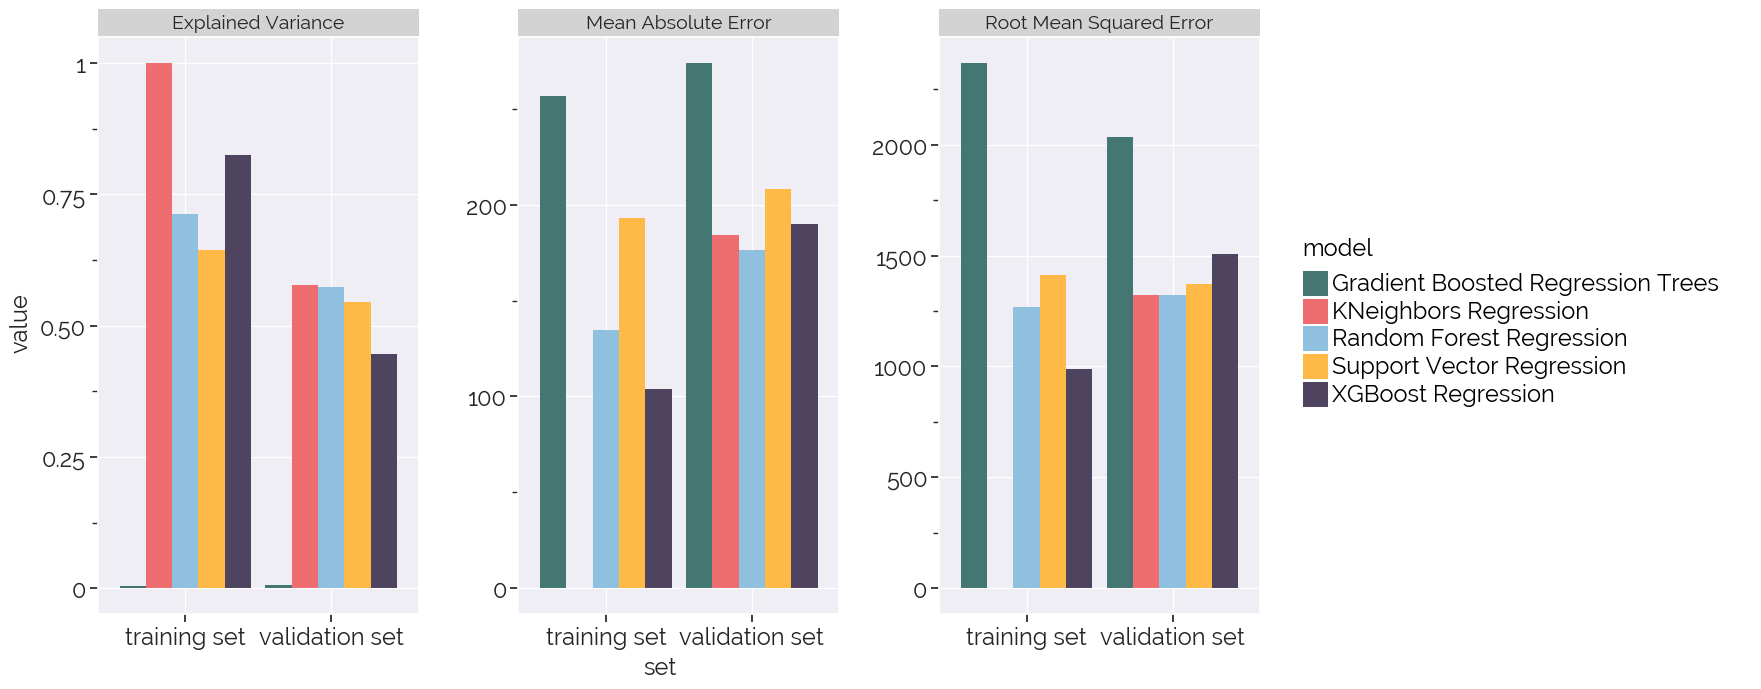

In [97]:
# plot comparison of model scores

draw = pd.melt(scores, id_vars=['model','set'])

(p9.ggplot(draw)
 + p9.geom_col(p9.aes('set', 'value', fill='model'), position='dodge')
 + p9.facet_wrap('variable', scales='free_y')
 + p9.scale_fill_manual(mycolors[:5])
 + p9.ylab('metric value') + p9.xlab('')
 + mytheme_wide
).draw();

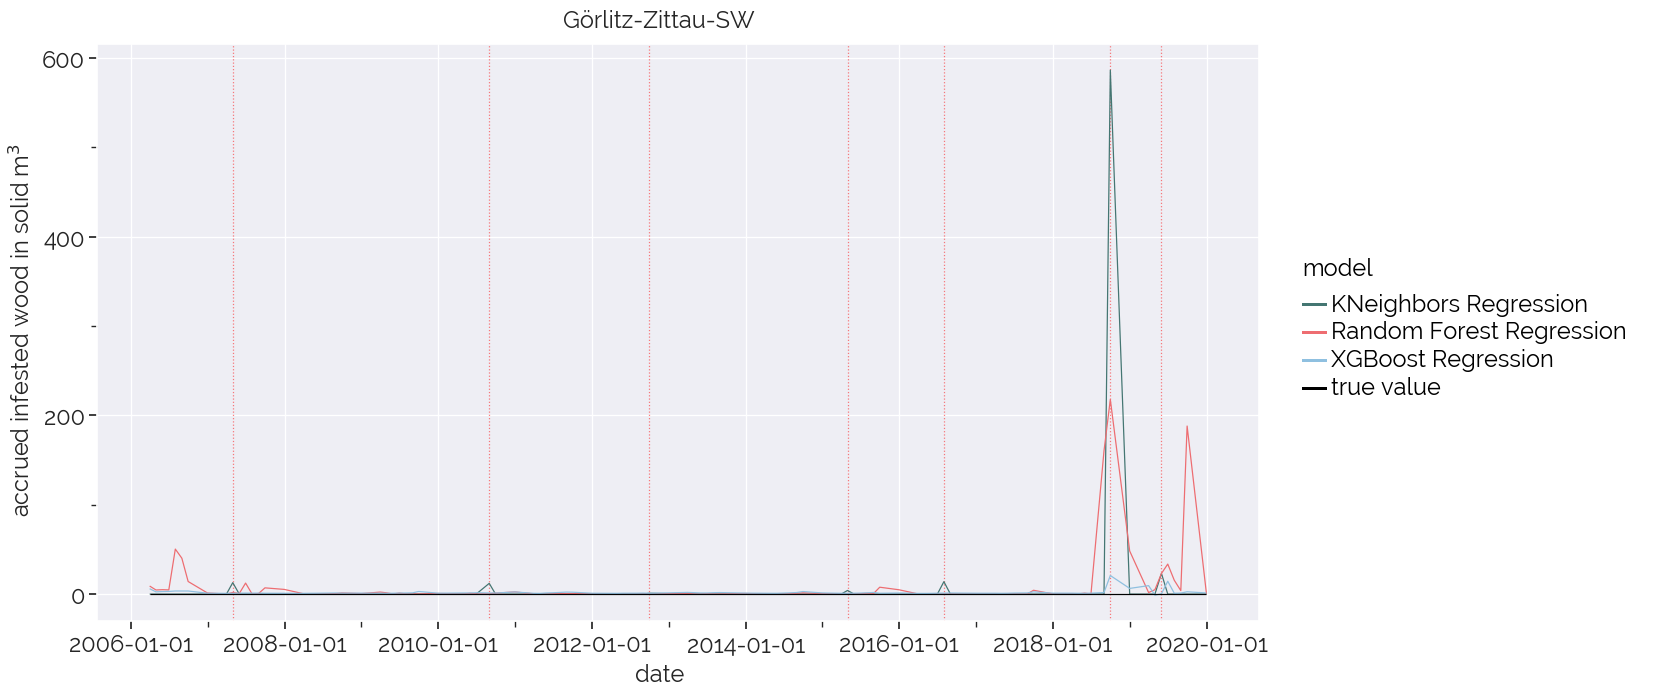

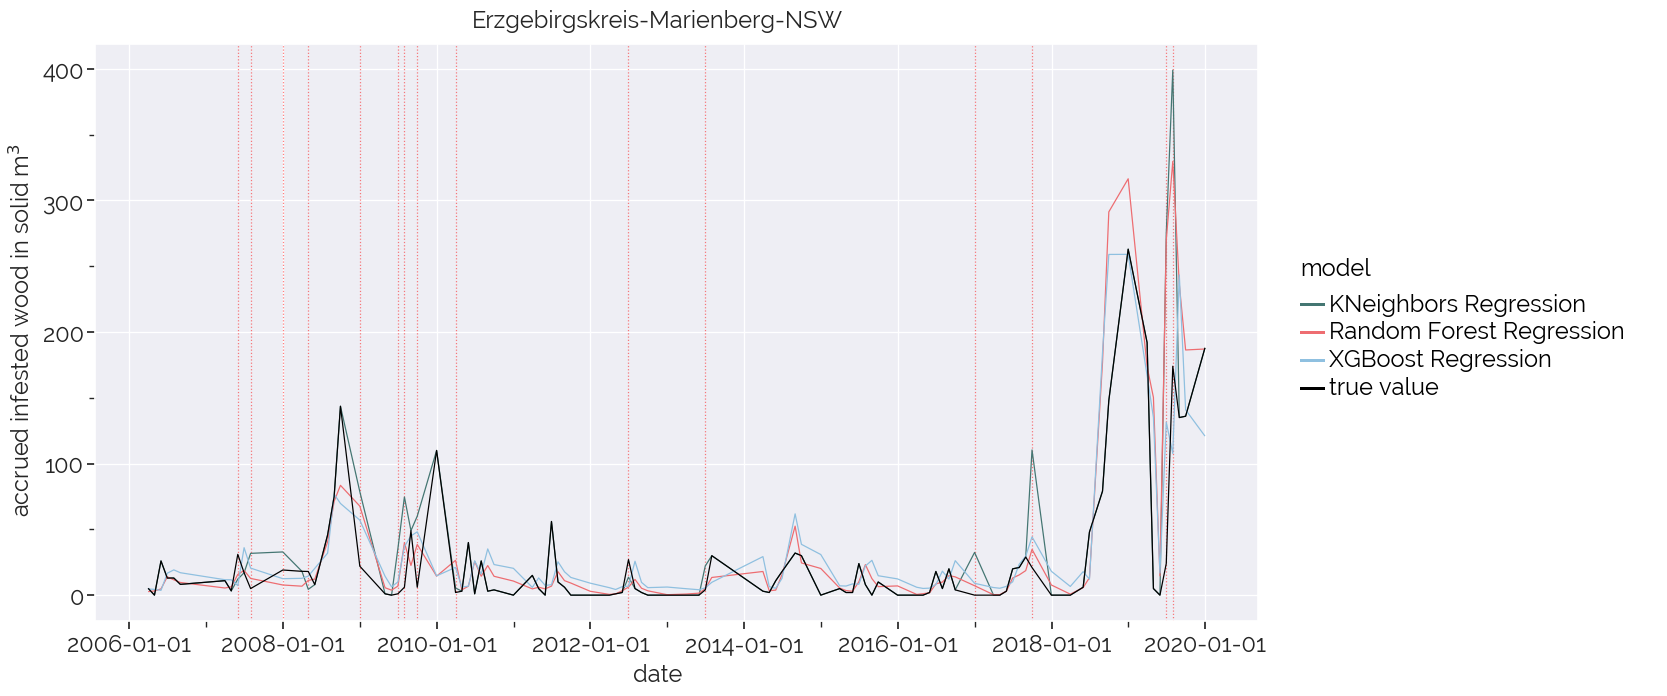

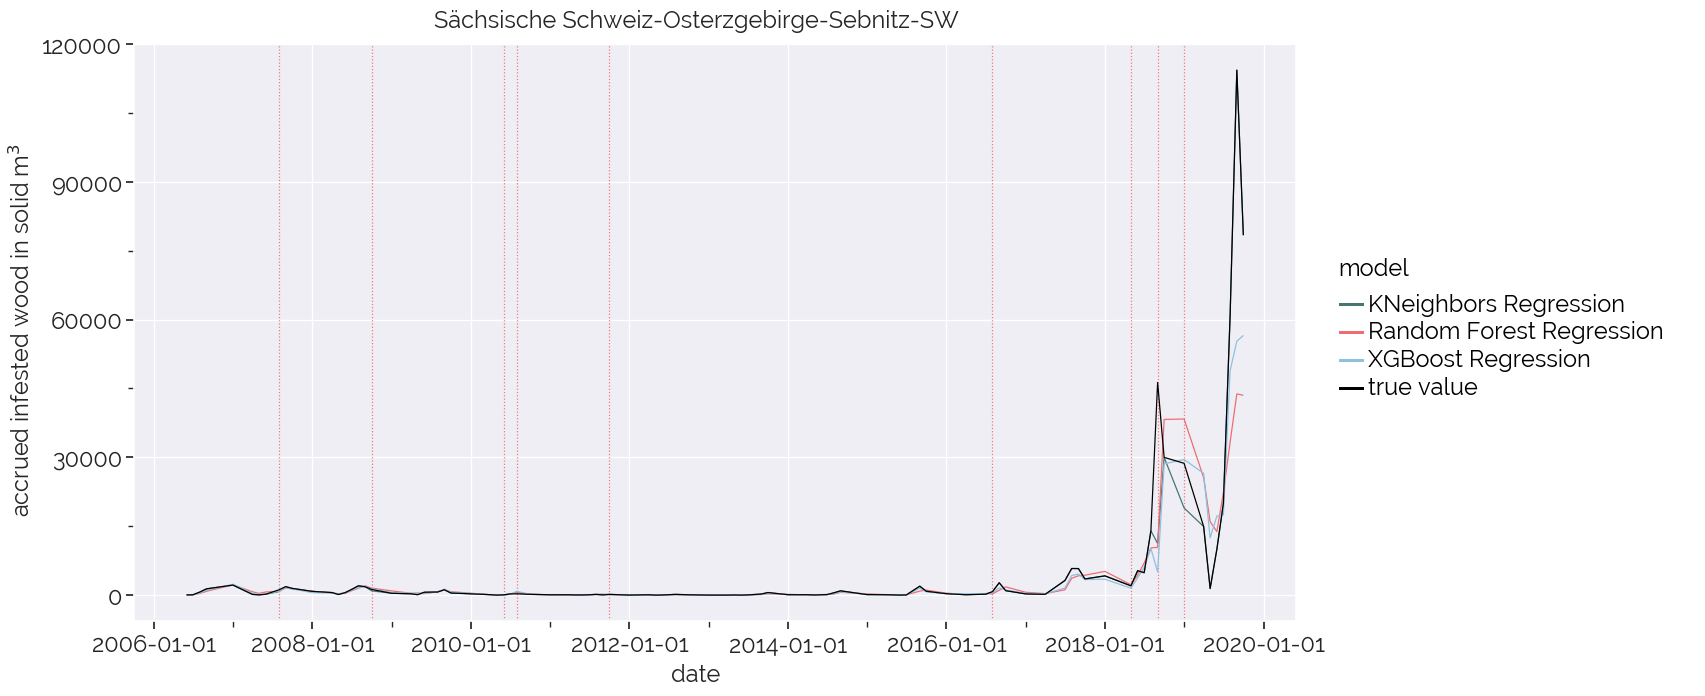

In [133]:
top_models = list(scores[scores['set'] == 'validation set'].sort_values('Mean Absolute Error', ascending=True)['model'])

id_subset = np.random.choice(results_df['id'].unique(), 3, replace=False)

for ID in id_subset:
    draw = results_df[results_df['id'] == ID]
    draw = pd.melt(draw, id_vars=['id', 'timestamp', 'set'], value_vars=['true value', top_models[0], top_models[1], top_models[2]])
    validation_ts = draw[draw['set'] == 'validation set']['timestamp']
    
    (p9.ggplot(draw)
        + p9.geom_vline(xintercept=validation_ts, color='red', size=.5, linetype='dotted', alpha=.5)
        + p9.geom_line(p9.aes('timestamp', 'value', color='variable'))
        + p9.scale_color_manual([mycolors[0], mycolors[1], mycolors[2], 'black'], name='model')
        + p9.xlab('date') + p9.ylab(r'accrued infested wood in solid m$^3$')
        + p9.labels.ggtitle(ID)
        + mytheme_wide
    ).draw();
    

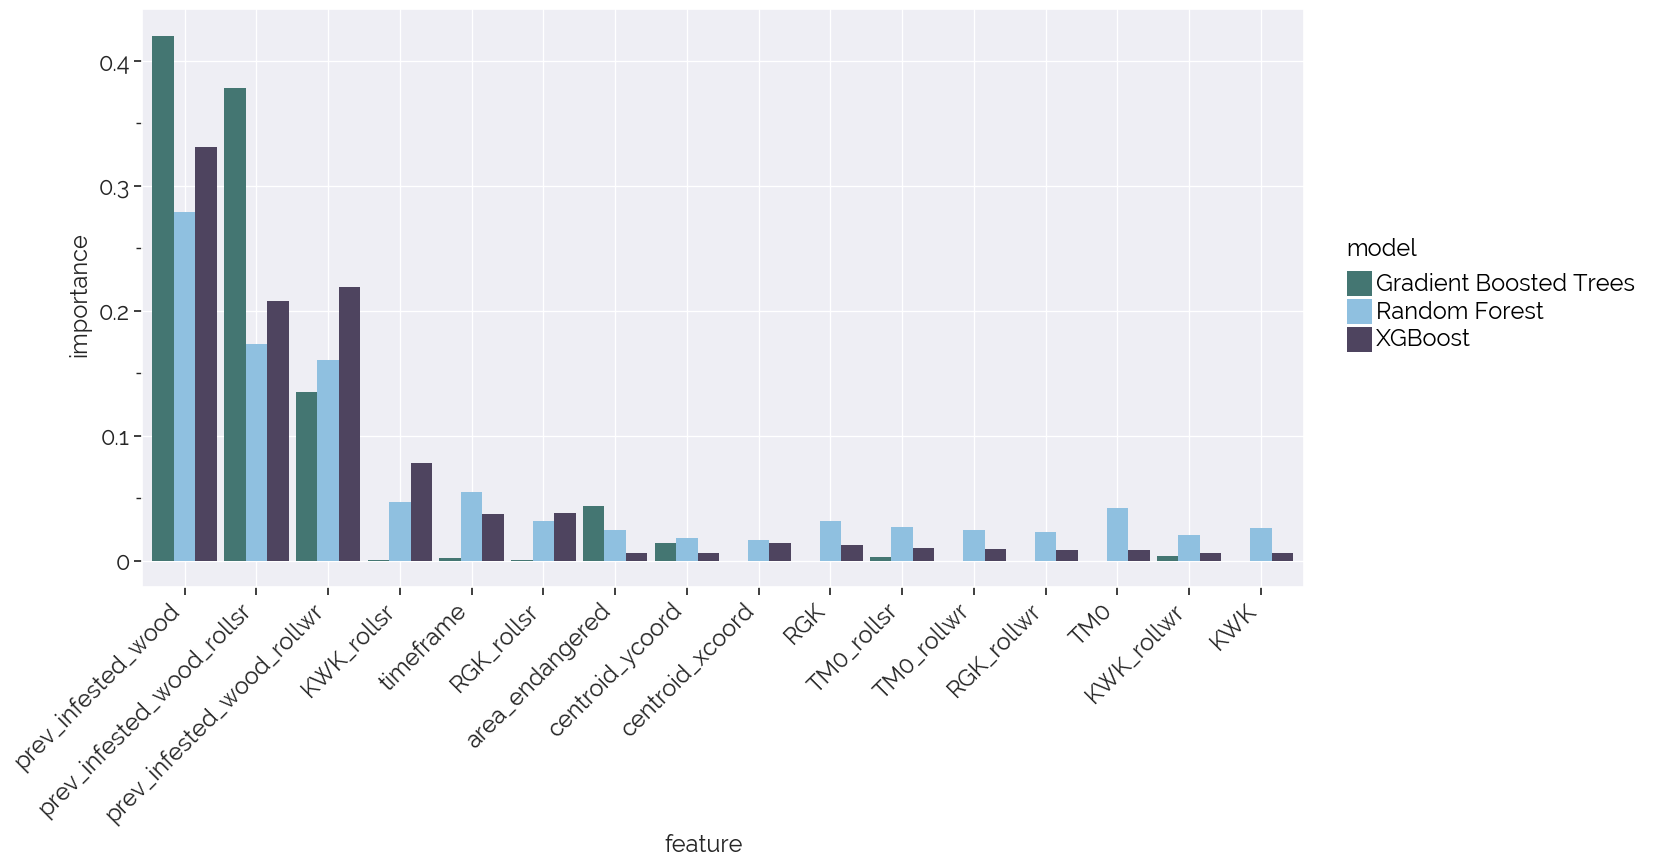

In [130]:
importances_names = X_train.columns
importances_xbgr = best_models[0]['regressor'].feature_importances_
importances_rfr = best_models[1]['regressor'].feature_importances_
importances_gbr = best_models[2]['regressor'].feature_importances_


draw = pd.melt(pd.DataFrame([importances_xbgr, importances_rfr, importances_gbr], 
                            columns=importances_names, 
                            index=['XGBoost', 'Random Forest', 'Gradient Boosted Trees']), 
               ignore_index=False)
(
    p9.ggplot(draw)
    + p9.geom_col(p9.aes('reorder(variable, -value)', 'value', fill=draw.index), position='dodge')
    + p9.scale_fill_manual([mycolors[0], mycolors[2], mycolors[4]], name='model') # each color manually so they match the other plots
    + p9.xlab('feature') + p9.ylab('importance')
    + mytheme_wide
    + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
).draw();

_______________________________________________________________________________________________________________________________________